In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle
import os
from random import sample
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import bpy
import random
import sys
import os
import objaverse
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
from src import *

objaverse._VERSIONED_PATH=os.path.join('../.objaverse', "hf-objaverse-v1")
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.15)

import logging
logging.disable(logging.CRITICAL)

# Filter only objects having one diffusion texture
##### ℹ️ This notebook requires `data/2-annotations_filtered_by_thumbnails.parquet`
This notebook downloads all the filtered objects and filter them based on the the textures they have.

In [2]:
annotations = pd.read_parquet('../data/2-annotations_filtered_by_thumbnails.parquet')

## Download the whole filtered dataset
This gonna take a while...

In [3]:
paths = objaverse.load_objects(
    annotations['uid'][:25000].to_list(), download_processes=64)
paths_glb=list(paths.values())

## How many GLB files have 1 Mesh, 1 UV map and 1 diffuse texture?
Let's check the number of meshes per GLB file first.

In [5]:
num_meshes = []
random.seed=42
indexes = random.choices(range(len(paths)), k=100)
for i in tqdm(indexes):
    load_glb(paths_glb[i])
    num_meshes.append(get_scene_stats()['mesh_count'])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 19.29it/s]


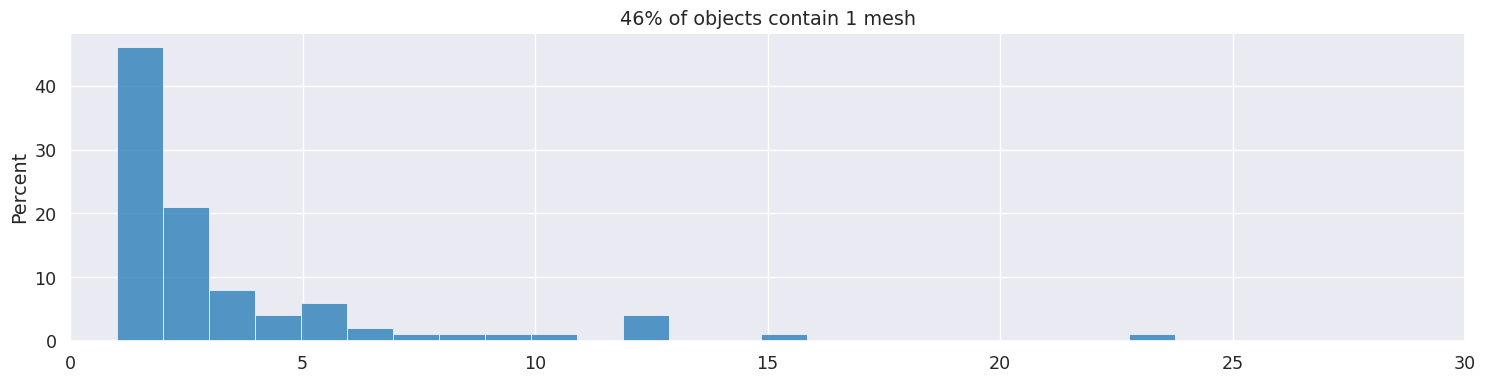

In [6]:
plt.figure(figsize=(18, 4))
sns.histplot(num_meshes, bins=max(num_meshes)+1, stat='percent')
plt.title(f'{len([x for x in num_meshes if x==1])/len(num_meshes)*100:.0f}% of objects contain 1 mesh')
plt.xlim(0,30)
plt.show()

##### 👉🏼 About $50\%$ of GLB files contain 1 and only one mesh object.
How many of these have 1 UV map?

In [7]:
num_uvs=[]
glbs_with_1_mesh=[paths_glb[indexes[i]] for i,x in enumerate(num_meshes) if x==1]
for glb in tqdm(glbs_with_1_mesh):
    mesh = next(x for x in load_glb(glb) if x.type=="MESH")
    num_uvs.append(get_mesh_stats(mesh)['uv_count'])

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:01<00:00, 33.06it/s]


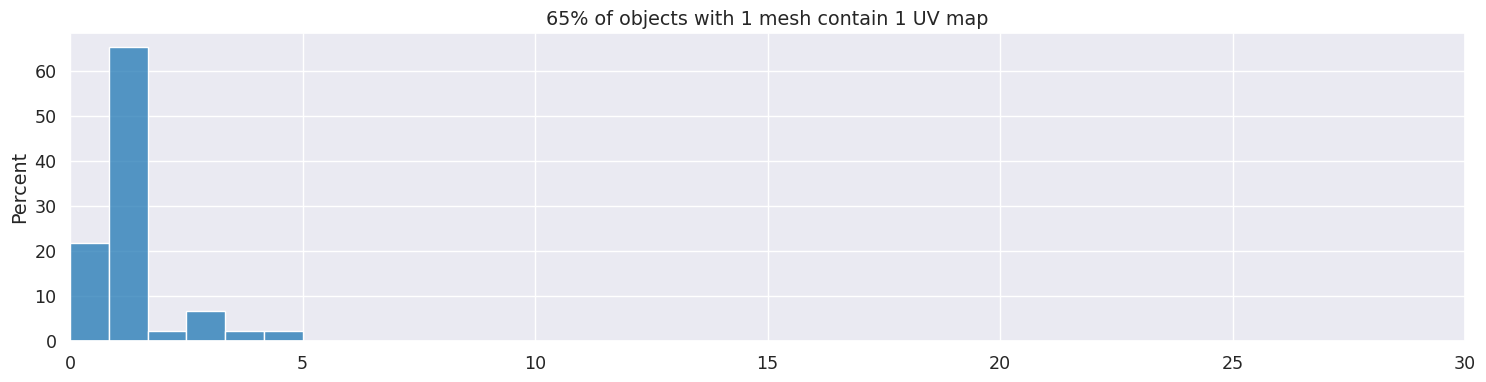

In [8]:
plt.figure(figsize=(18, 4))
sns.histplot(num_uvs, bins=max(num_uvs)+1, stat='percent')
plt.title(f'{len([x for x in num_uvs if x==1])/len(num_uvs)*100:.0f}% of objects with 1 mesh contain 1 UV map')
plt.xlim(0,30)
plt.show()

##### 👉🏼 About $75\%$ of them have exactly 1 UV map.

In [9]:
num_textures = []
glbs_with_1_mesh_and_1_uv = [
    x for i, x in enumerate(glbs_with_1_mesh) if num_uvs[i] == 1]
for glb in tqdm(glbs_with_1_mesh_and_1_uv):
    mesh = next(x for x in load_glb(glb) if x.type == "MESH")
    num_textures.append(get_mesh_stats(mesh)['texture_count'])

100%|██████████| 30/30 [00:00<00:00, 32.83it/s]


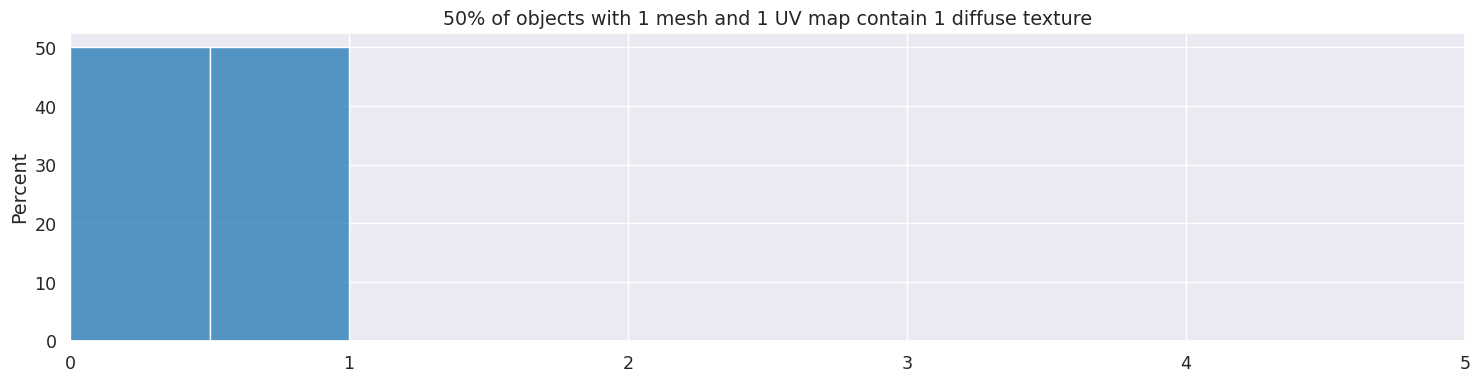

In [10]:
plt.figure(figsize=(18, 4))
sns.histplot(num_textures, bins=max(num_textures)+1, stat='percent')
plt.title(f'{len([x for x in num_textures if x==1])/len(num_textures)*100:.0f}% of objects with 1 mesh and 1 UV map contain 1 diffuse texture')
plt.xlim(0,5)
plt.show()

##### 👉🏼 About $60\%$ of them have exactly 1 UV map.
Thus we end up with about $50\% \times 75\% \times 60\% = 22.5\%$ meeting the requirements.

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.06it/s]

Image_0
Image_0.png
Info: Use existing file (instead of packed): //Image_0.png
Image_0
Image_0.png
Info: Use existing file (instead of packed): //Image_0.png
Image_1
Image_1.png
Info: Use existing file (instead of packed): //Image_1.png


 75%|███████▌  | 3/4 [00:00<00:00,  6.52it/s]

Image_0
Image_0.png
Info: Use existing file (instead of packed): //Image_0.png
Image_0
Image_0.jpg
Info: Use existing file (instead of packed): //Image_0.jpg
Image_1
Image_1.png
Info: Use existing file (instead of packed): //Image_1.png


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

Image_2
Image_2.png
Info: Use existing file (instead of packed): //Image_2.png


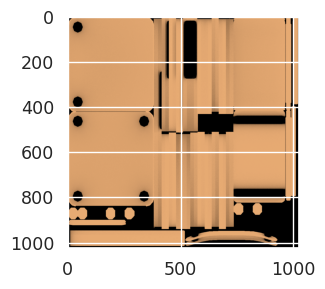

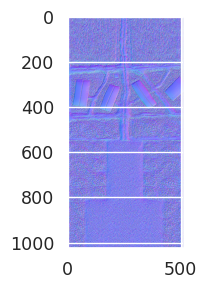

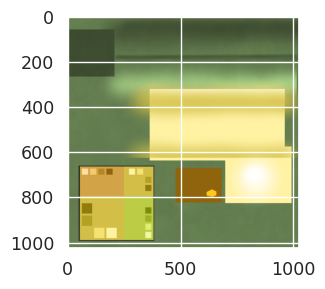

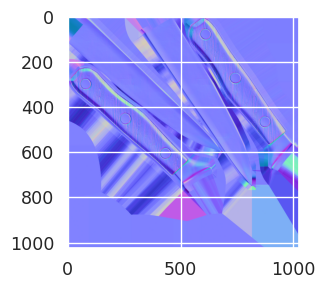

In [29]:
glbs_with_1_mesh_and_1_uv_and_1_tex = [
    x for i, x in enumerate(glbs_with_1_mesh_and_1_uv) if num_textures[i] == 1]
for glb in tqdm(glbs_with_1_mesh_and_1_uv_and_1_tex[::4]):
    load_glb(glb)
    textures = get_textures()
    _, ax = plt.subplots(figsize=(3,  3))
    for i,tex in enumerate(textures):
        ax.imshow(tex)
plt.show()